In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# -*- coding: utf-8 -*-
"""
Data preparation & augmentation for LGG MRI Segmentation
- Splits into train/val/test
- Applies Albumentations (3x augmentation on train)
- Saves paired images/masks into ./augmented/<split>/{images,masks}
"""

import os
import cv2
import numpy as np
import albumentations as A
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# ===== 1) Dataset root (Kaggle path) =====
BASE_DIR = "/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m"

# ===== 2) Collect image/mask paths =====
# Masks follow "*_mask.tif"; corresponding image path is the same name without "_mask"
mask_paths = sorted(glob(os.path.join(BASE_DIR, "*", "*_mask.tif")))
image_paths = [p.replace("_mask", "") for p in mask_paths]

# ===== 3) Train/Val/Test split (80/10/10) =====
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs, temp_masks, test_size=0.5, random_state=42
)

print(f"Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

# ===== 4) Data augmentation (Albumentations) =====
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ElasticTransform(p=0.2),
])

# ===== 5) Create output folders =====
for subset in ["train", "val", "test"]:
    os.makedirs(f"augmented/{subset}/images", exist_ok=True)
    os.makedirs(f"augmented/{subset}/masks", exist_ok=True)

# ===== 6) Save paired images/masks (with optional augmentation) =====
def save_pairs(images, masks, subset, augment_data=False):
    """
    Reads grayscale images & masks, applies optional augmentation,
    and saves them under augmented/<subset>/{images,masks}.
    - For training, if augment_data=True, creates 3 augmented copies per pair.
    - For val/test, keeps a single copy without augmentation.
    """
    for i, (img_path, mask_path) in tqdm(
        enumerate(zip(images, masks)),
        total=len(images),
        desc=f"{subset.upper()}"
    ):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            print(f"Skipped (could not read): {img_path} or {mask_path}")
            continue

        num_copies = 3 if augment_data else 1

        for j in range(num_copies):
            if augment_data:
                transformed = augment(image=img, mask=mask)
                aug_img, aug_mask = transformed["image"], transformed["mask"]
            else:
                aug_img, aug_mask = img, mask

            cv2.imwrite(f"augmented/{subset}/images/img_{i}_{j}.tif", aug_img)
            cv2.imwrite(f"augmented/{subset}/masks/mask_{i}_{j}.tif", aug_mask)

# ===== 7) Run saving for each split =====
save_pairs(train_imgs, train_masks, subset="train", augment_data=True)
save_pairs(val_imgs,   val_masks,   subset="val",   augment_data=False)
save_pairs(test_imgs,  test_masks,  subset="test",  augment_data=False)

print("✅ Augmented images and masks saved successfully.")


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Train: 3143, Val: 393, Test: 393


TEST: 100%|██████████| 393/393 [00:02<00:00, 173.54it/s]


✅ Augmented images and masks saved successfully.


TEST: 100%|██████████| 393/393 [00:01<00:00, 239.81it/s]


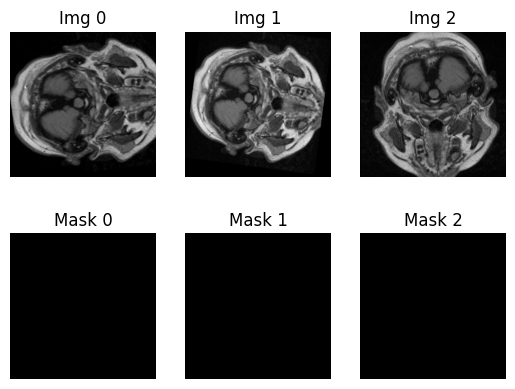

In [6]:
import matplotlib.pyplot as plt

#Test the Agumentaed Data

idx = 0  # Try with any i value
imgs = [cv2.imread(f"augmented/train/images/img_{idx}_{j}.tif", cv2.IMREAD_GRAYSCALE) for j in range(3)]
masks = [cv2.imread(f"augmented/train/masks/mask_{idx}_{j}.tif", cv2.IMREAD_GRAYSCALE) for j in range(3)]

for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(imgs[i], cmap='gray')
    plt.title(f'Img {i}')
    plt.axis('off')
    plt.subplot(2, 3, i+4)
    plt.imshow(masks[i], cmap='gray')
    plt.title(f'Mask {i}')
    plt.axis('off')
plt.show()

Train: 9429
Val: 393
Test: 393
Using 2 GPUs!
Epoch 1/30 | Train Loss: 0.7984 | Train Dice: 0.5011 | Train IoU: 0.4724
                 | Val Loss: 0.7682 | Val Dice: 0.5645 | Val IoU: 0.5330
Epoch 2/30 | Train Loss: 0.7388 | Train Dice: 0.5843 | Train IoU: 0.5528
                 | Val Loss: 0.7457 | Val Dice: 0.5856 | Val IoU: 0.5537
Epoch 3/30 | Train Loss: 0.6816 | Train Dice: 0.6349 | Train IoU: 0.6075
                 | Val Loss: 0.6156 | Val Dice: 0.6693 | Val IoU: 0.6484
Epoch 4/30 | Train Loss: 0.6871 | Train Dice: 0.6537 | Train IoU: 0.6340
                 | Val Loss: 0.7248 | Val Dice: 0.6451 | Val IoU: 0.6446
Epoch 5/30 | Train Loss: 0.6734 | Train Dice: 0.6258 | Train IoU: 0.5975
                 | Val Loss: 0.6401 | Val Dice: 0.6190 | Val IoU: 0.5863
Epoch 6/30 | Train Loss: 0.6101 | Train Dice: 0.6572 | Train IoU: 0.6241
                 | Val Loss: 0.6238 | Val Dice: 0.6135 | Val IoU: 0.5784
Epoch 7/30 | Train Loss: 0.5945 | Train Dice: 0.6605 | Train IoU: 0.6264
      

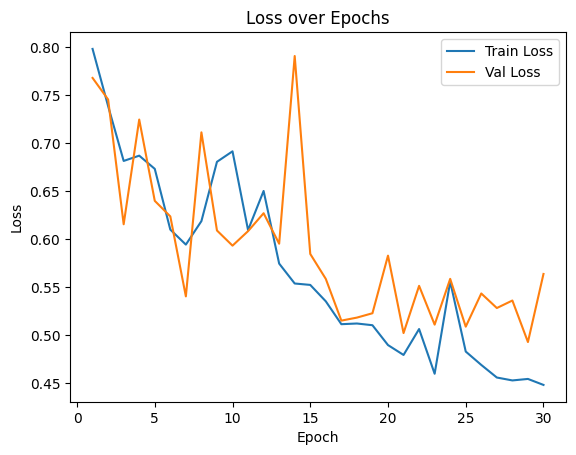

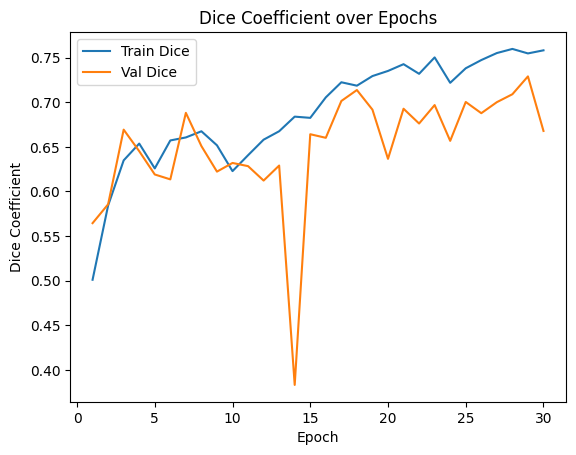

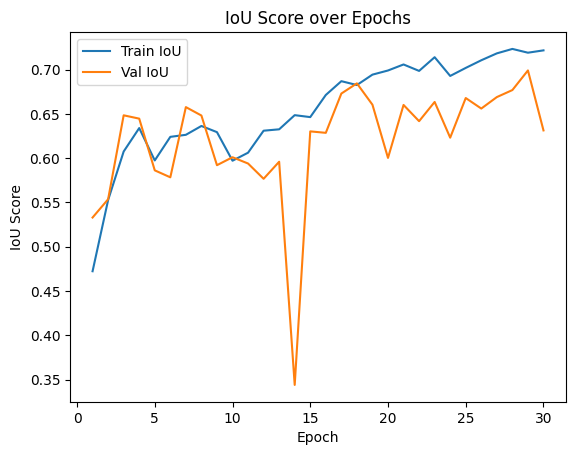


Sample Validation Predictions:


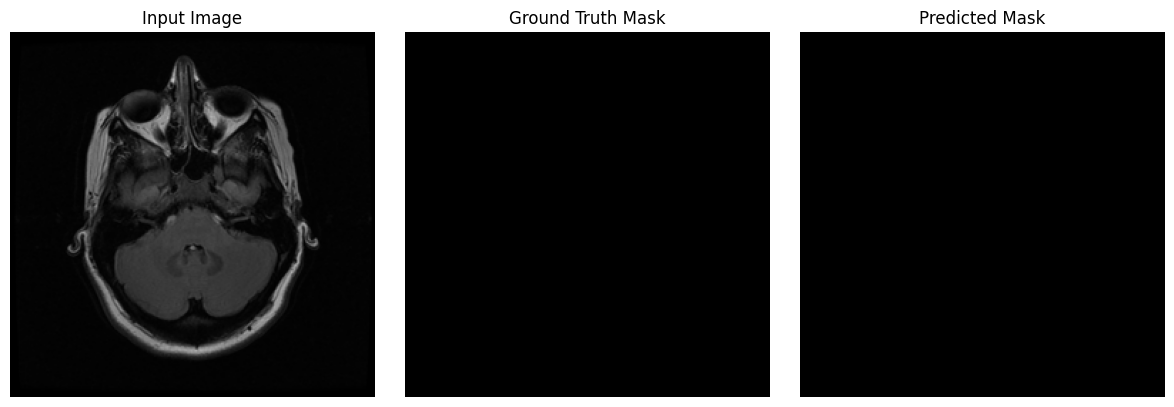

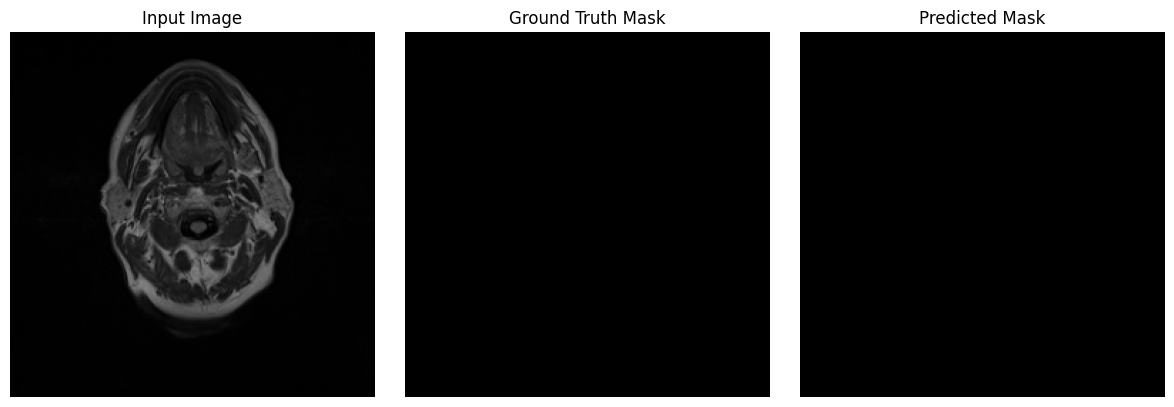

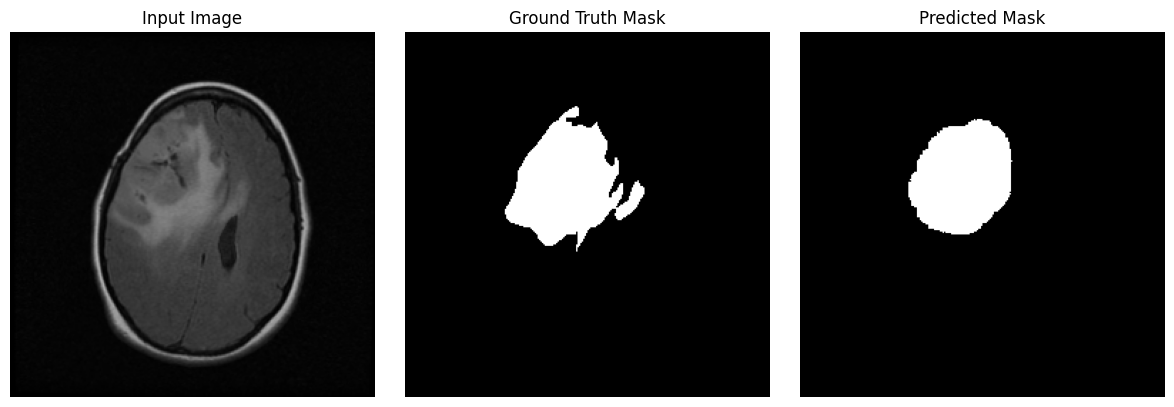

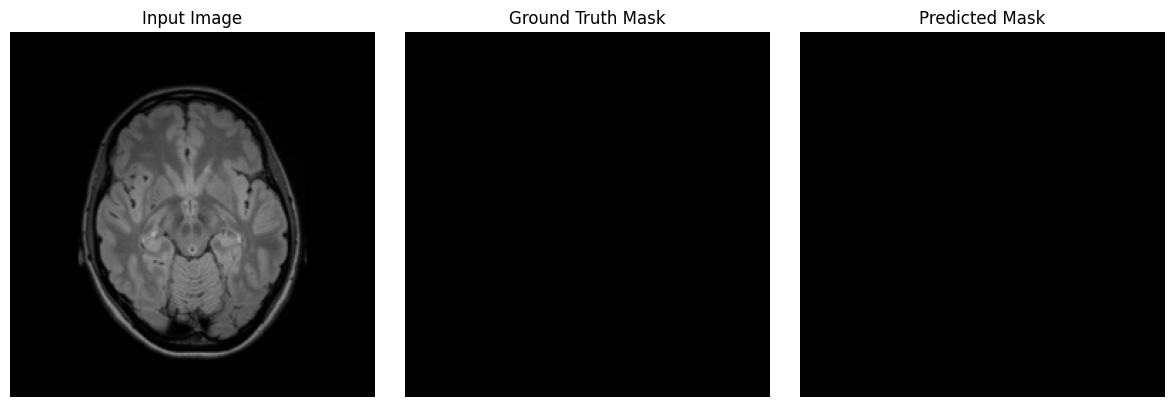

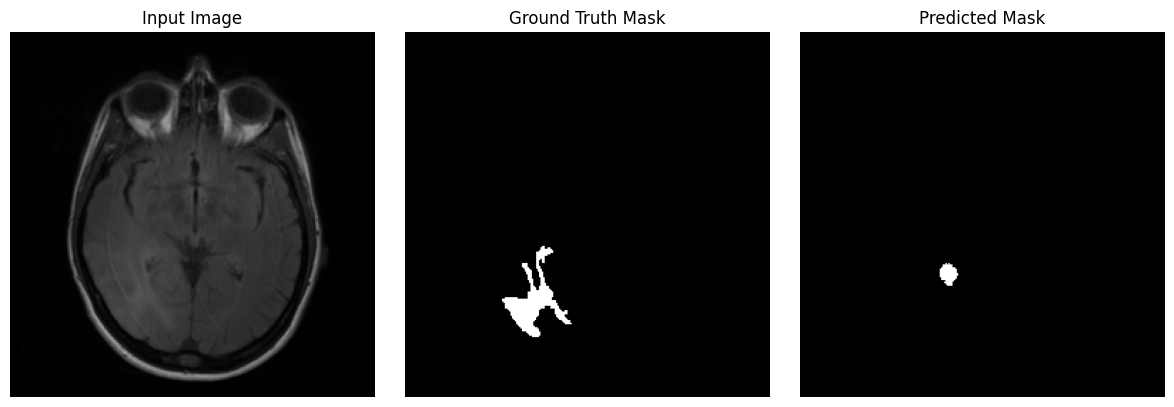

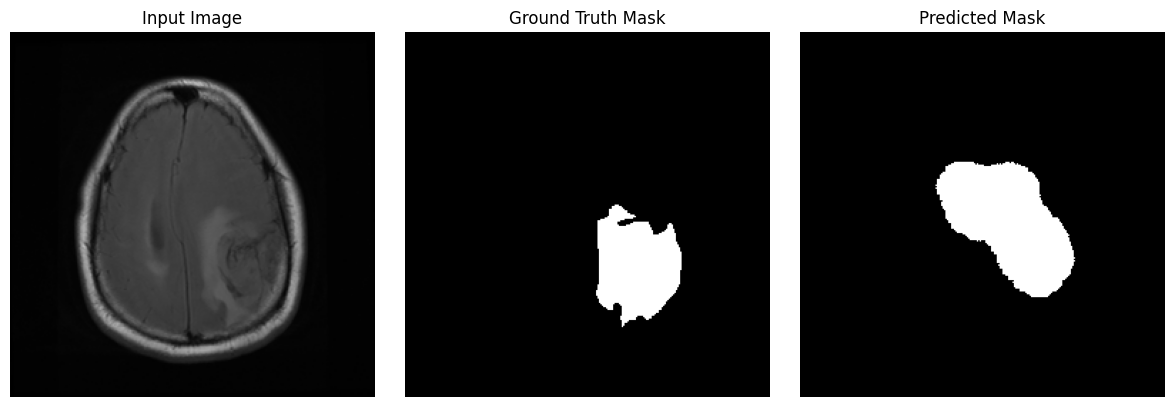

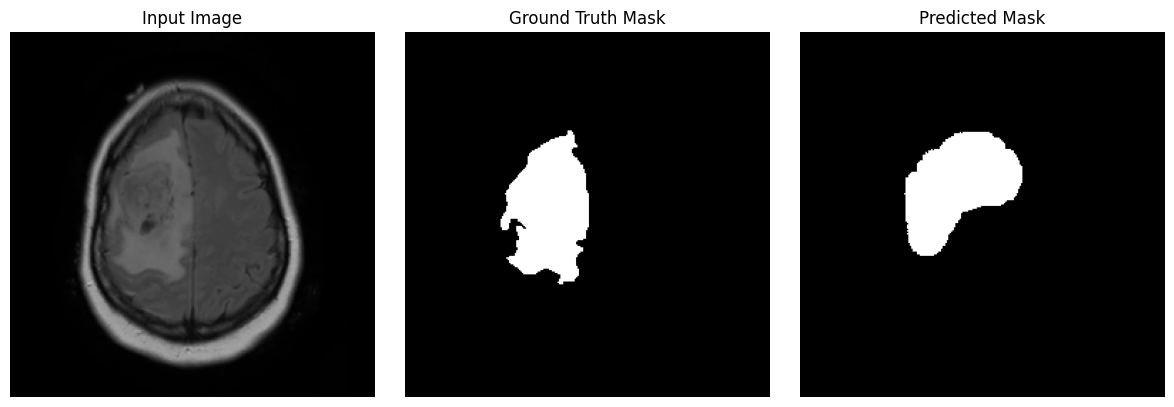

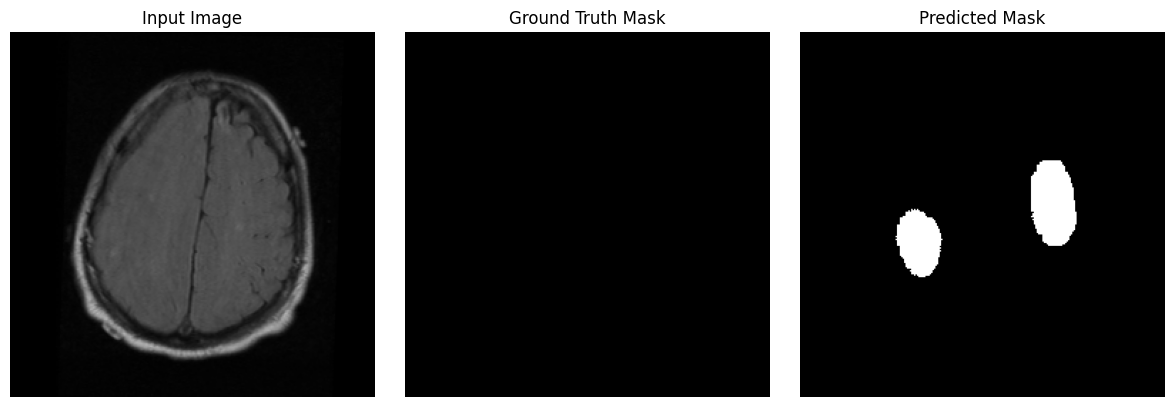

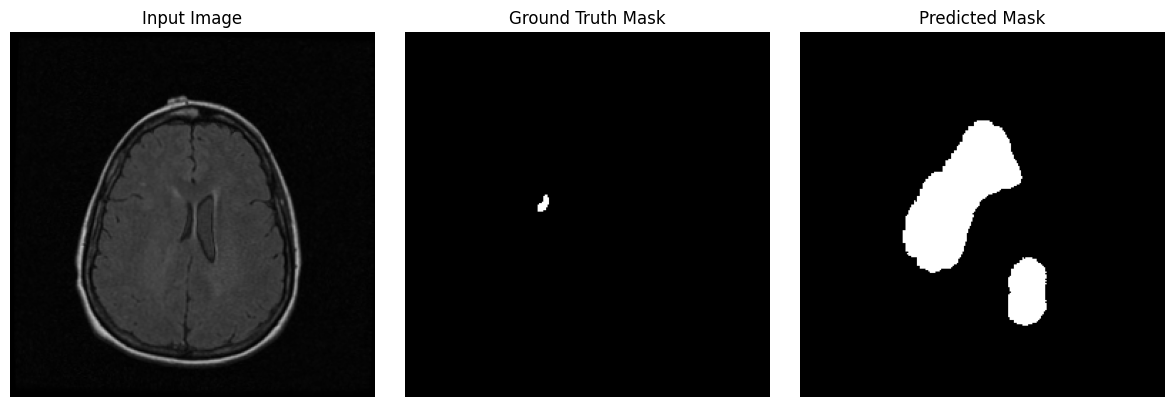

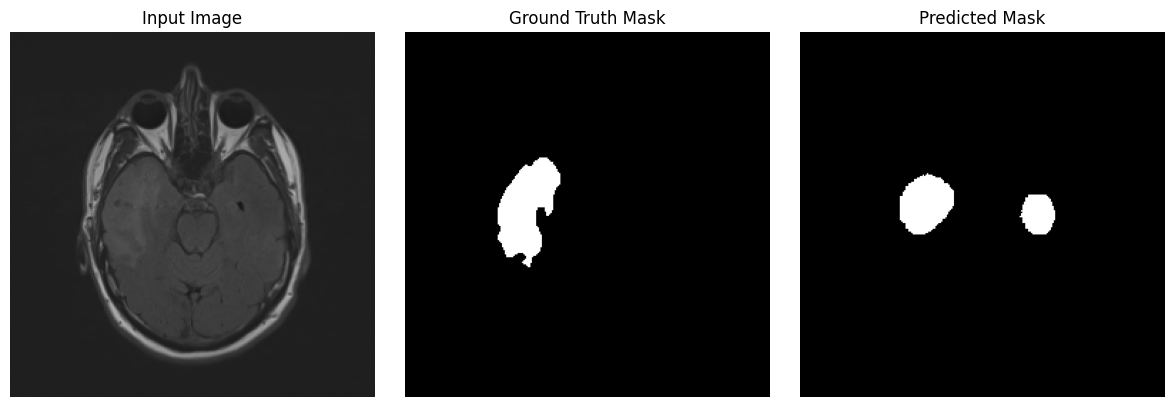


Sample Test Predictions:


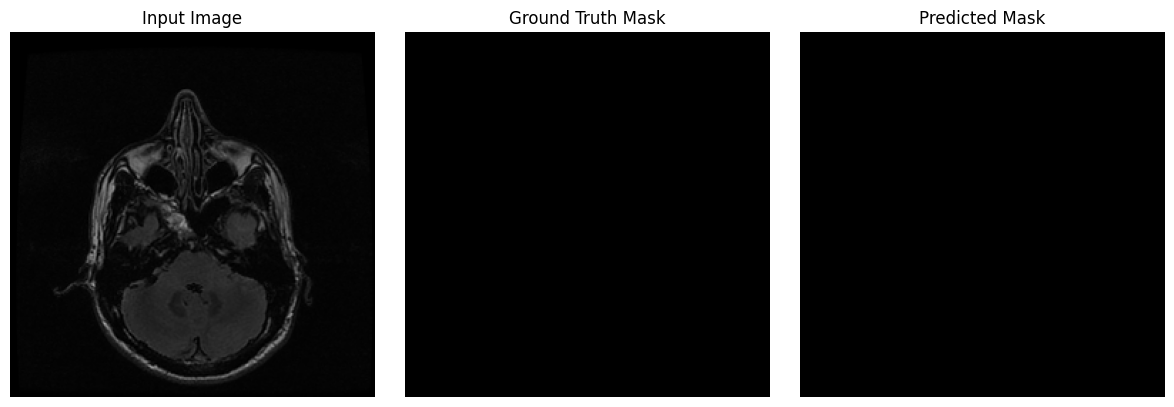

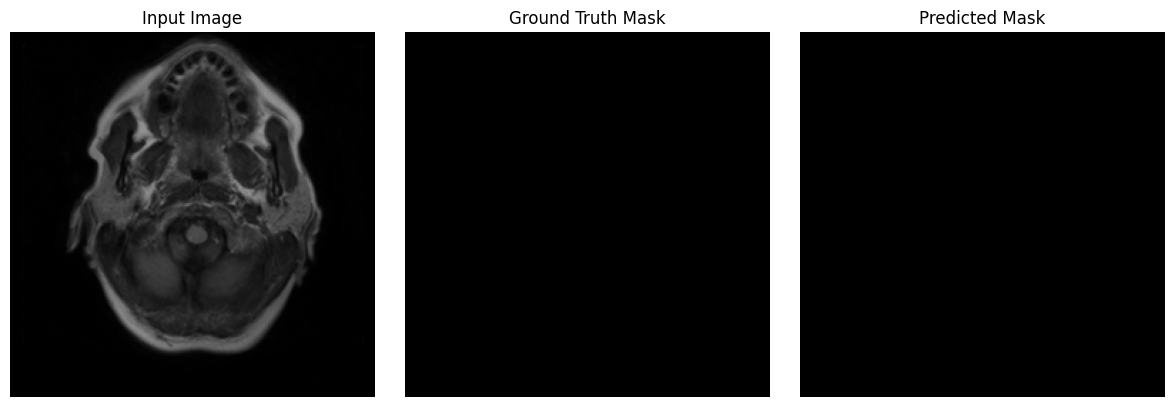

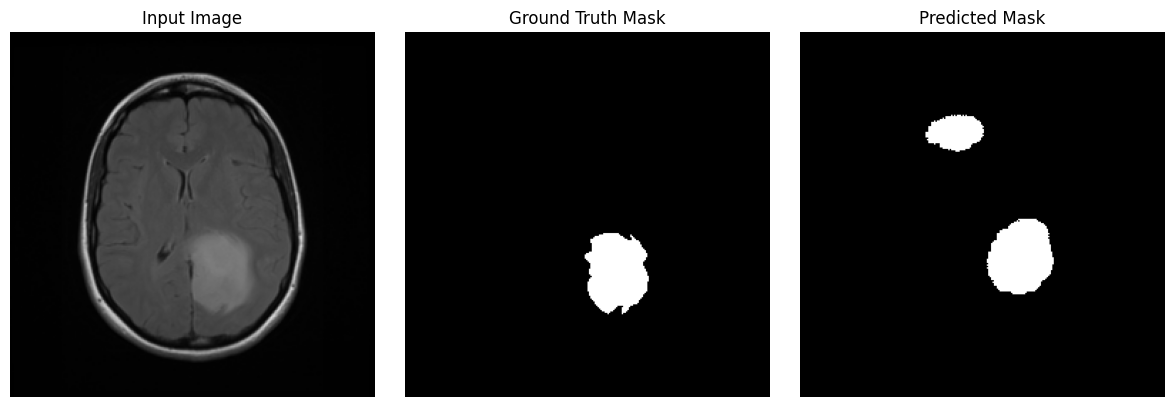

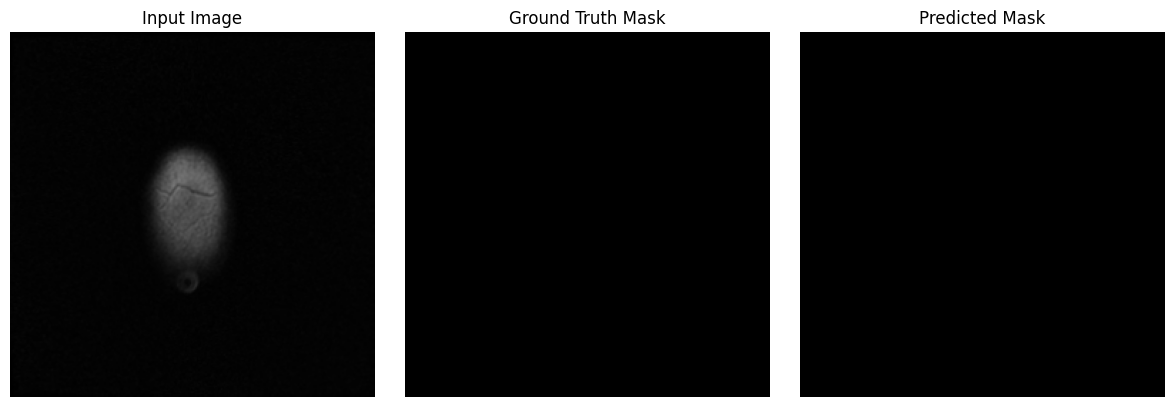

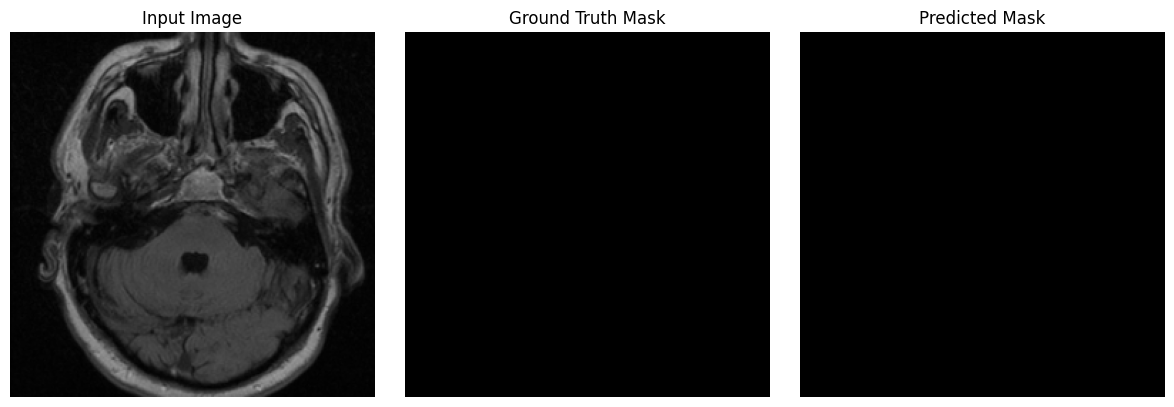

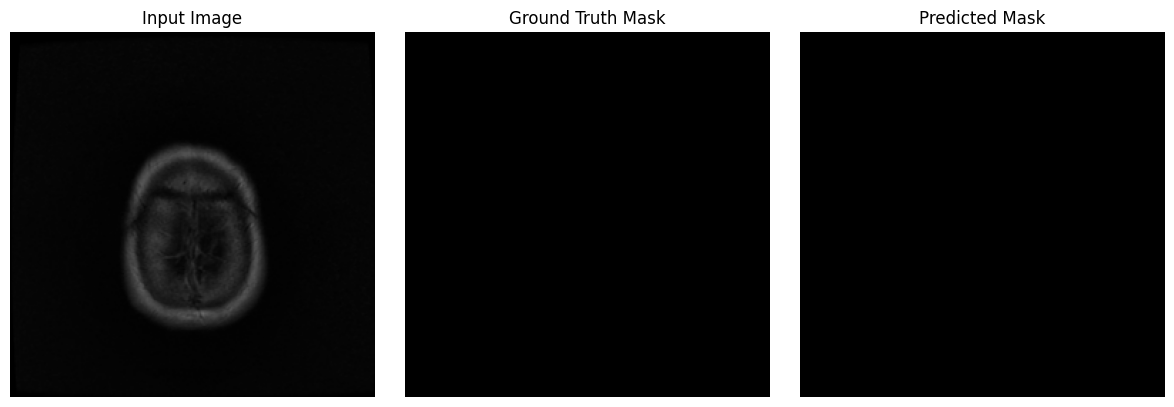

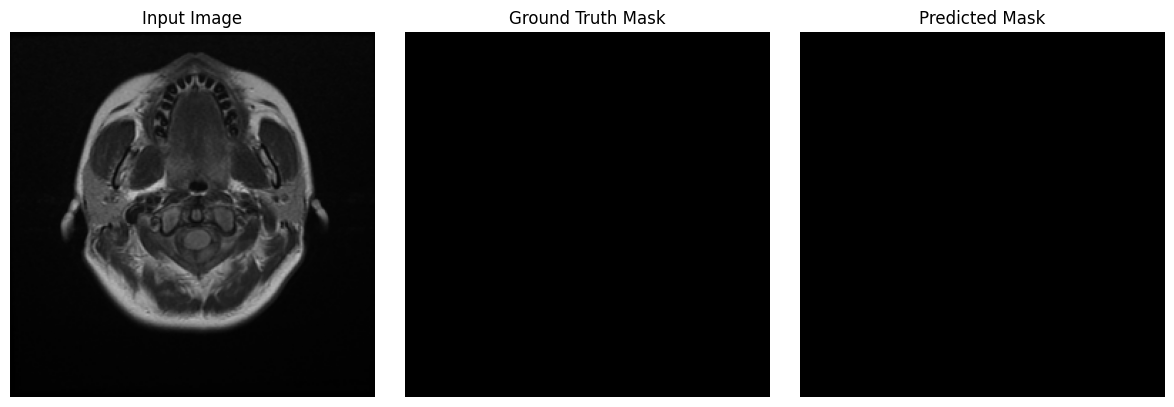

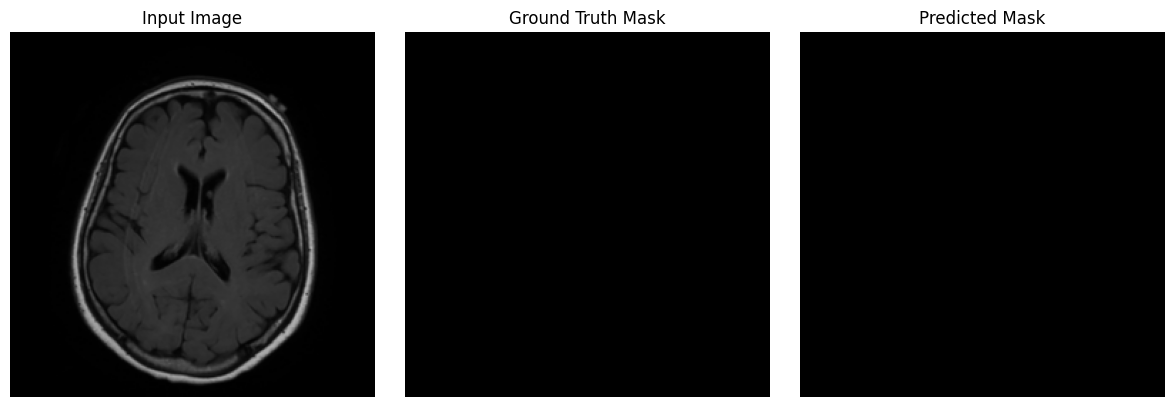

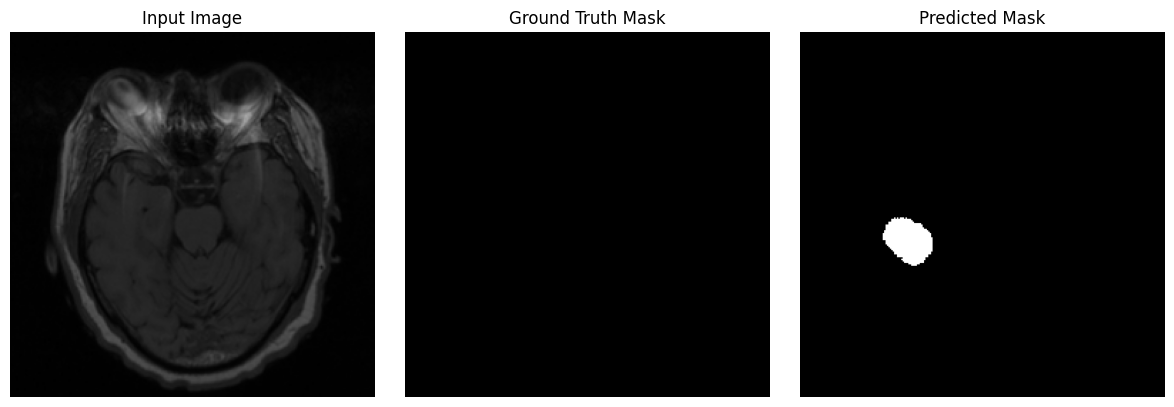

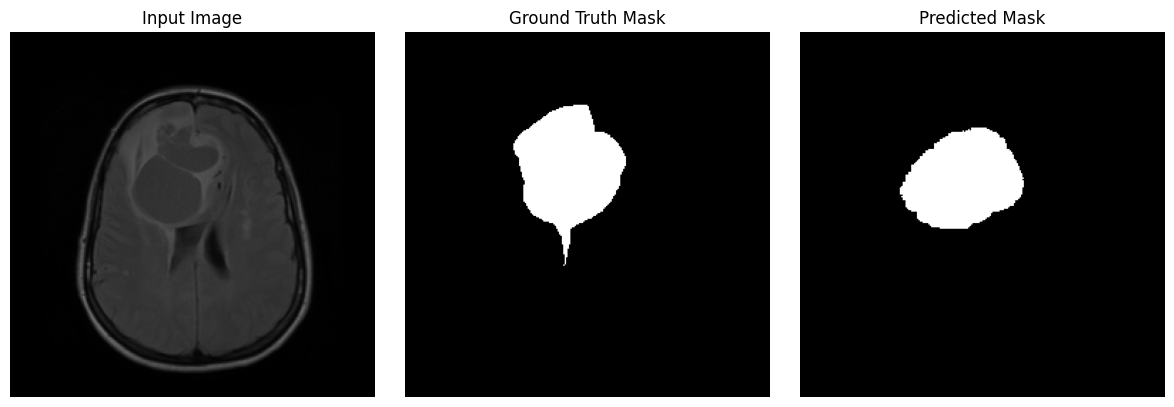


=== Test Results ===
Test Dice Coefficient (mean): 0.6775
Test IoU Score (mean): 0.6419
Test CCR (mean): 0.9867


In [7]:
import os
import cv2
import numpy as np
import albumentations as A
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import matplotlib.pyplot as plt

# ========================
# 2. Dataset & Dataloader
# ========================

class MRISegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_paths = sorted(glob(os.path.join(image_dir, "*.tif")))
        self.mask_paths = sorted(glob(os.path.join(mask_dir, "*.tif")))
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256))
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        img = img.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0
        img = np.repeat(np.expand_dims(img, axis=0), 3, axis=0)
        mask = np.expand_dims(mask, axis=0)
        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

train_dataset = MRISegmentationDataset("augmented/train/images", "augmented/train/masks")
val_dataset = MRISegmentationDataset("augmented/val/images", "augmented/val/masks")
test_dataset = MRISegmentationDataset("augmented/test/images", "augmented/test/masks")

print("Train:", len(train_dataset), flush=True)
print("Val:", len(val_dataset), flush=True)
print("Test:", len(test_dataset), flush=True)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# ========================
# 3. Model, Loss, Metrics
# ========================

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)
        preds = preds.view(-1)
        targets = targets.view(-1)
        intersection = (preds * targets).sum()
        return 1 - (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)

class UNetVGG16(nn.Module):
    def __init__(self):
        super(UNetVGG16, self).__init__()
        vgg = models.vgg16(pretrained=True)
        self.encoder = vgg.features
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)
        return x

def calculate_iou(preds, masks, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    intersection = (preds * masks).sum(dim=(1, 2, 3))
    union = ((preds + masks) >= 1).float().sum(dim=(1, 2, 3))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

def calculate_dice(preds, masks, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    intersection = (preds * masks).sum(dim=(1, 2, 3))
    total = preds.sum(dim=(1, 2, 3)) + masks.sum(dim=(1, 2, 3))
    dice = (2 * intersection + 1e-6) / (total + 1e-6)
    return dice.mean().item()

def show_prediction(img, pred_mask, true_mask):
    img = img.permute(1, 2, 0).cpu().numpy()
    pred_mask = torch.sigmoid(pred_mask).squeeze().cpu().detach().numpy()
    true_mask = true_mask.squeeze().cpu().numpy()
    pred_mask = (pred_mask > 0.5).astype(np.uint8)
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img, cmap='gray')
    axs[0].set_title("Input Image")
    axs[1].imshow(true_mask, cmap='gray')
    axs[1].set_title("Ground Truth Mask")
    axs[2].imshow(pred_mask, cmap='gray')
    axs[2].set_title("Predicted Mask")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# ========================
# 4. Training
# ========================

# Multi-GPU support with DataParallel
model = UNetVGG16()
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = DiceLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

num_epochs = 30
train_loss_history, val_loss_history = [], []
train_dice_history, val_dice_history = [], []
train_iou_history, val_iou_history = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, dice_epoch, iou_epoch = 0, 0, 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        preds = model(images)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        dice_epoch += calculate_dice(preds, masks)
        iou_epoch += calculate_iou(preds, masks)
    avg_loss = total_loss / len(train_loader)
    avg_dice = dice_epoch / len(train_loader)
    avg_iou = iou_epoch / len(train_loader)
    train_loss_history.append(avg_loss)
    train_dice_history.append(avg_dice)
    train_iou_history.append(avg_iou)

    # Validation phase
    model.eval()
    val_loss, val_dice, val_iou = 0, 0, 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            loss = criterion(preds, masks)
            val_loss += loss.item()
            val_dice += calculate_dice(preds, masks)
            val_iou += calculate_iou(preds, masks)
    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    val_iou /= len(val_loader)
    val_loss_history.append(val_loss)
    val_dice_history.append(val_dice)
    val_iou_history.append(val_iou)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f} | Train Dice: {avg_dice:.4f} | Train IoU: {avg_iou:.4f}", flush=True)
    print(f"                 | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}", flush=True)

# ========================
# 5. Plot Results
# ========================

epochs = range(1, num_epochs + 1)
plt.figure()
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs")
plt.show()

plt.figure()
plt.plot(epochs, train_dice_history, label='Train Dice')
plt.plot(epochs, val_dice_history, label='Val Dice')
plt.xlabel("Epoch")
plt.ylabel("Dice Coefficient")
plt.legend()
plt.title("Dice Coefficient over Epochs")
plt.show()

plt.figure()
plt.plot(epochs, train_iou_history, label='Train IoU')
plt.plot(epochs, val_iou_history, label='Val IoU')
plt.xlabel("Epoch")
plt.ylabel("IoU Score")
plt.legend()
plt.title("IoU Score over Epochs")
plt.show()

# ========================
# 6. Show Predictions & Test Evaluation
# ========================

print("\nSample Validation Predictions:", flush=True)
N = 10
counter = 0
for images, masks in val_loader:
    preds = model(images.to(device))
    show_prediction(images[0].cpu(), preds[0].cpu(), masks[0].cpu())
    counter += 1
    if counter == N:
        break

print("\nSample Test Predictions:", flush=True)
counter = 0
for images, masks in test_loader:
    preds = model(images.to(device))
    show_prediction(images[0].cpu(), preds[0].cpu(), masks[0].cpu())
    counter += 1
    if counter == N:
        break

print("\n=== Test Results ===", flush=True)
test_dice, test_iou, test_ccr = [], [], []
for images, masks in test_loader:
    images, masks = images.to(device), masks.to(device)
    preds = model(images)
    dice = calculate_dice(preds, masks)
    iou = calculate_iou(preds, masks)
    test_dice.append(dice)
    test_iou.append(iou)
    pred_mask = (torch.sigmoid(preds) > 0.5).float()
    true_mask = (masks > 0.5).float()
    correct_bg = ((true_mask == 0) & (pred_mask == 0)).sum().item()
    correct_fg = ((true_mask == 1) & (pred_mask == 1)).sum().item()
    correct = correct_bg + correct_fg
    total = true_mask.numel()
    ccr = correct / total
    test_ccr.append(ccr)
print(f"Test Dice Coefficient (mean): {np.mean(test_dice):.4f}", flush=True)
print(f"Test IoU Score (mean): {np.mean(test_iou):.4f}", flush=True)
print(f"Test CCR (mean): {np.mean(test_ccr):.4f}", flush=True)
